# Feature Selection for Kaggle Tabular Playground Series Jan 2021 Using Python and Scikit-learn
### David Lowe
### May 25, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: Feature selection involves picking the set of features that are most relevant to the target variable. This can help reduce the complexity of our model and minimize the resources required for training and inference. The Kaggle Tabular Playground Series Jan 2021 dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: In this notebook, we will run through the different techniques in performing feature selection on the dataset. We will leverage the Scikit-learn library which features various machine learning algorithms and has built-in implementations of various feature selection methods. We will compare which method works best for this particular dataset.

ANALYSIS: The feature selection technique that yielded the best RMSE score was Recursive Feature Elimination (RFE). Its RMSE for the training dataset was 0.7082.

CONCLUSION: In this iteration, the RFE technique appeared to be suitable for modeling this dataset. We should follow up on the feature selection exercise by modeling the whole dataset using the selected attributes.

Dataset Used: Kaggle Tabular Playground Series Jan 2021 Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jan-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-jan-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFE, SequentialFeatureSelector, SelectFromModel
# from sklearn.pipeline import Pipeline
# from sklearn import compose
# from sklearn import impute

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 4

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'neg_mean_squared_error'

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id     cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
0   1  0.670390  0.811300  0.643968  0.291791  0.284117  0.855953  0.890700  0.285542  0.558245  0.779418  0.921832  0.866772  0.878733   
1   3  0.388053  0.621104  0.686102  0.501149  0.643790  0.449805  0.510824  0.580748  0.418335  0.432632  0.439872  0.434971  0.369957   
2   4  0.834950  0.227436  0.301584  0.293408  0.606839  0.829175  0.506143  0.558771  0.587603  0.823312  0.567007  0.677708  0.882938   
3   5  0.820708  0.160155  0.546887  0.726104  0.282444  0.785108  0.752758  0.823267  0.574466  0.580843  0.769594  0.818143  0.914281   
4   8  0.935278  0.421235  0.303801  0.880214  0.665610  0.830131  0.487113  0.604157  0.874658  0.863427  0.983575  0.900464  0.935918   

     cont14    target  
0  0.305411  7.243043  
1  0.369484  8.203331  
2  0.303047  7.776091  
3  0.279528  6.957716  
4  0.435772  7.951046  


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [12]:
print(df_dataset_import.describe(include='all'))

                  id          cont1          cont2          cont3          cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000   
mean   249825.145857       0.506873       0.497898       0.521557       0.515683       0.502022       0.526515       0.487890   
std    144476.732562       0.203976       0.228159       0.200770       0.233035       0.220701       0.217909       0.181096   
min         1.000000      -0.082263      -0.031397       0.020967       0.152761       0.276377       0.066166      -0.097666   
25%    124656.500000       0.343078       0.319170       0.344096       0.294935       0.284108       0.356163       0.346600   
50%    249738.500000       0.484005       0.553209       0.551471       0.482880       0.451733       0.470988       0.466825   
75%    374836.250000       0.643789       0.731263       0.648315       0.748705       0.670660  

In [13]:
print(df_dataset_import.isna().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isna().sum().sum())

id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

      cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
0  0.670390  0.811300  0.643968  0.291791  0.284117  0.855953  0.890700  0.285542  0.558245  0.779418  0.921832  0.866772  0.878733   
1  0.388053  0.621104  0.686102  0.501149  0.643790  0.449805  0.510824  0.580748  0.418335  0.432632  0.439872  0.434971  0.369957   
2  0.834950  0.227436  0.301584  0.293408  0.606839  0.829175  0.506143  0.558771  0.587603  0.823312  0.567007  0.677708  0.882938   
3  0.820708  0.160155  0.546887  0.726104  0.282444  0.785108  0.752758  0.823267  0.574466  0.580843  0.769594  0.818143  0.914281   
4  0.935278  0.421235  0.303801  0.880214  0.665610  0.830131  0.487113  0.604157  0.874658  0.863427  0.983575  0.900464  0.935918   

     cont14    target  
0  0.305411  7.243043  
1  0.369484  8.203331  
2  0.303047  7.776091  
3  0.279528  6.957716  
4  0.435772  7.951046  


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont1   300000 non-null  float64
 1   cont2   300000 non-null  float64
 2   cont3   300000 non-null  float64
 3   cont4   300000 non-null  float64
 4   cont5   300000 non-null  float64
 5   cont6   300000 non-null  float64
 6   cont7   300000 non-null  float64
 7   cont8   300000 non-null  float64
 8   cont9   300000 non-null  float64
 9   cont10  300000 non-null  float64
 10  cont11  300000 non-null  float64
 11  cont12  300000 non-null  float64
 12  cont13  300000 non-null  float64
 13  cont14  300000 non-null  float64
 14  target  300000 non-null  float64
dtypes: float64(15)
memory usage: 34.3 MB


In [16]:
print(df_dataset_import.describe(include='all'))

               cont1          cont2          cont3          cont4          cont5          cont6          cont7          cont8  \
count  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.506873       0.497898       0.521557       0.515683       0.502022       0.526515       0.487890       0.525163   
std         0.203976       0.228159       0.200770       0.233035       0.220701       0.217909       0.181096       0.216221   
min        -0.082263      -0.031397       0.020967       0.152761       0.276377       0.066166      -0.097666       0.217260   
25%         0.343078       0.319170       0.344096       0.294935       0.284108       0.356163       0.346600       0.341486   
50%         0.484005       0.553209       0.551471       0.482880       0.451733       0.470988       0.466825       0.483460   
75%         0.643789       0.731263       0.648315       0.748705       0.670660       0.694043  

In [17]:
print(df_dataset_import.isna().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isna().sum().sum())

cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 15) df_features_train.shape: (300000, 14) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


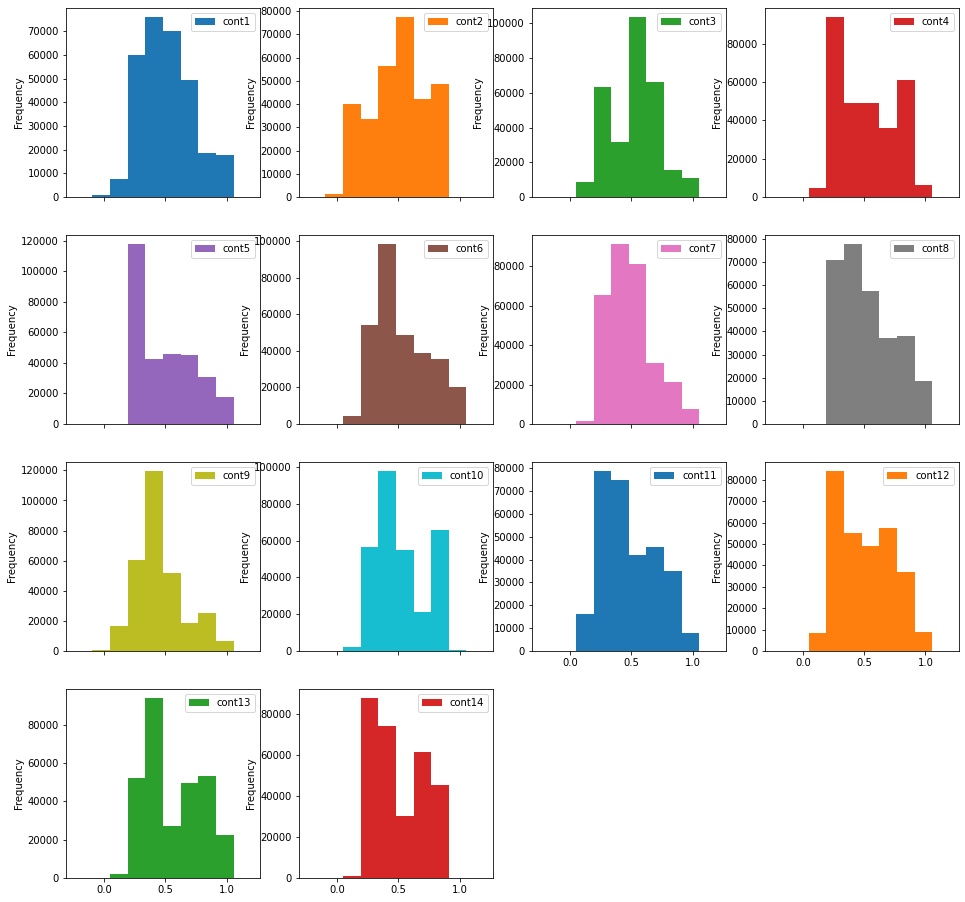

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


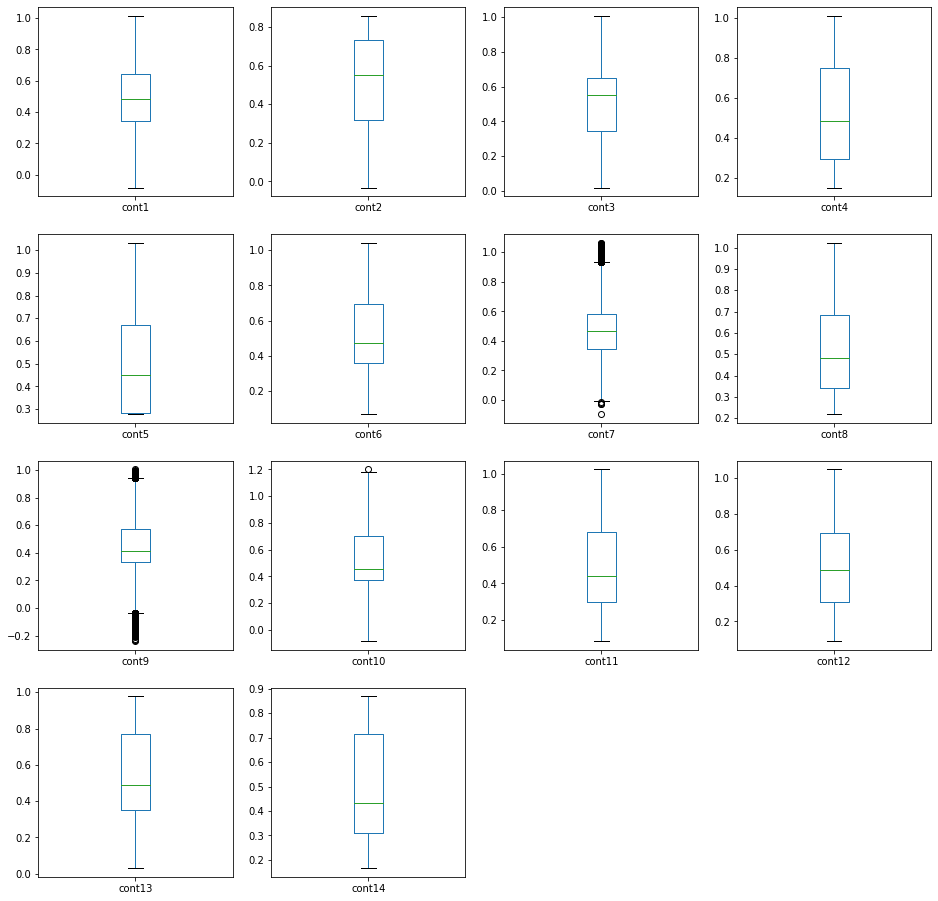

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

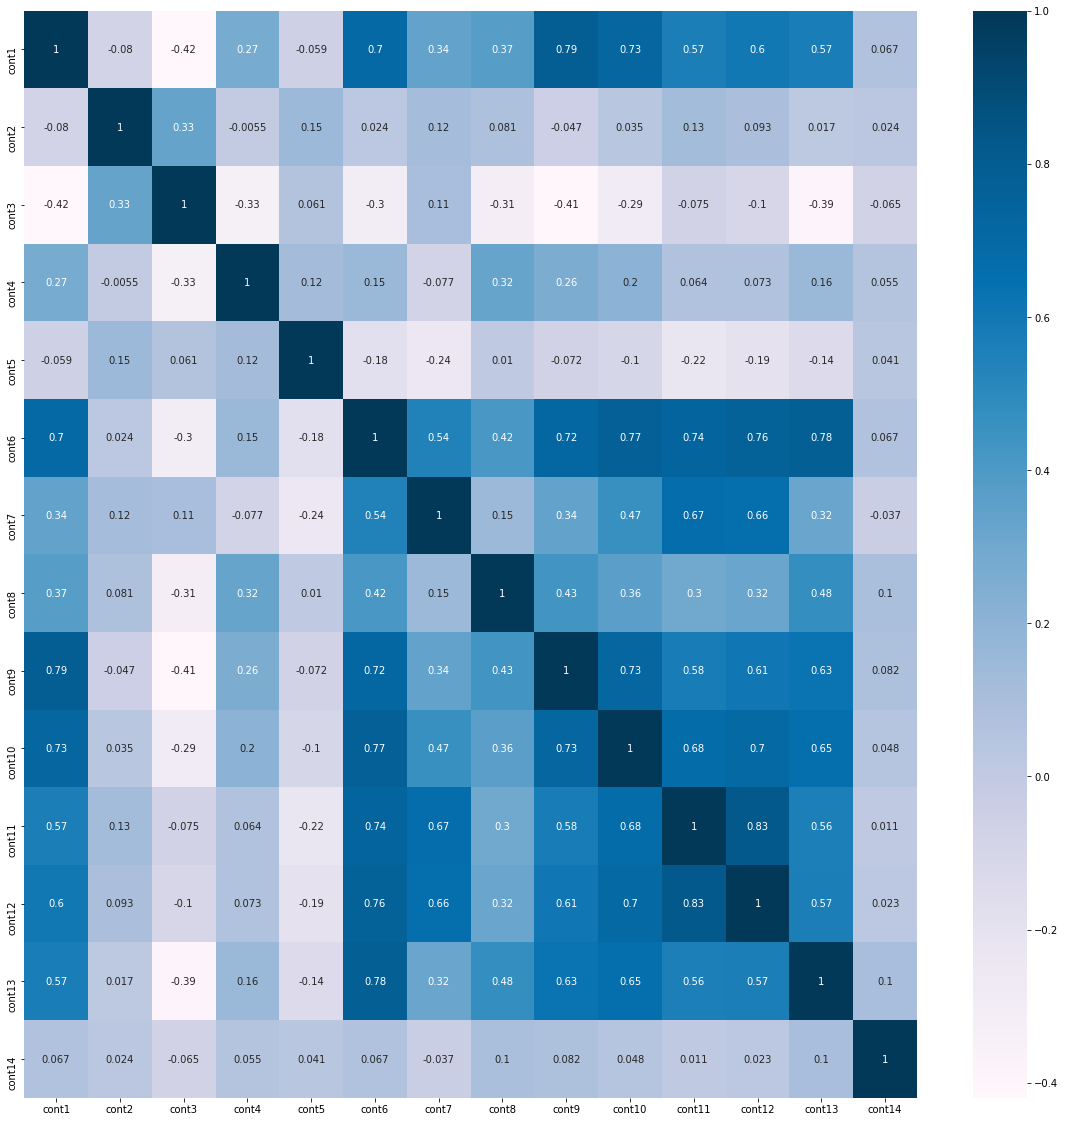

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training, Validation, and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Not applicable for this iteration of the project

### 3.c) Training Data Balancing

In [30]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [31]:
def fit_model(X, Y):
    '''Use an ExtraTreesRegressor model for measuring performance.'''
    
    # define the model to use
    model = ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)
    
    # Train the model
    model.fit(X, Y)
    
    return model

In [32]:
def calculate_metrics(model, X_val, y_val):
    '''Get model evaluation metrics on the test set.'''
    
    # Get model predictions
    y_predict = model.predict(X_val)
    
    # Calculate evaluation metrics for assesing performance of the model.
    mae = median_absolute_error(y_val, y_predict)
    mse = mean_squared_error(y_val, y_predict)
    rmse = math.sqrt(mean_squared_error(y_val, y_predict))
    r2 = r2_score(y_val, y_predict)
    
    return mae, mse, rmse, r2

In [33]:
def train_and_get_metrics(df_features, df_target):
    '''Train a Random Forest Regressor and get evaluation metrics'''

    # Split train and validation sets
    features_train, features_val, target_train, target_val = train_test_split(df_features, df_target, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
#     print("features_train.shape: {} target_train.shape: {}".format(features_train.shape, target_train.shape))
#     print("features_val.shape: {} target_val.shape: {}".format(features_val.shape, target_val.shape))

    # Finalize the training and validation datasets for the feature selection activities
    features_train_values = features_train.to_numpy()
    target_train_values = target_train.ravel()
#     print("features_train_values.shape: {} target_train_values.shape: {}".format(features_train_values.shape, target_train_values.shape))
    features_val_values = features_val.to_numpy()
    target_val_values = target_val.ravel()
#     print("features_val_values.shape: {} target_val_values.shape: {}".format(features_val_values.shape, target_val_values.shape))

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    fs_model = fit_model(features_train_values, target_train_values)

    # Make predictions on test dataset and calculate metrics.
    mae, mse, rmse, r2 = calculate_metrics(fs_model, features_val_values, target_val_values)

    return mae, mse, rmse, r2

In [34]:
def evaluate_model_on_features(df_features, df_target):
    '''Train model and display evaluation metrics.'''
    
    # Train the model, predict values and get metrics
    mae, mse, rmse, r2 = train_and_get_metrics(df_features, df_target)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[mae, mse, rmse, r2, df_features.shape[1]]], columns=['MAE', 'MSE', 'RMSE', 'R2', 'Feature Count'])
    
    return display_df

In [35]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(df_features_train, df_target_train)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
print(results.head())

                   MAE       MSE      RMSE        R2  Feature Count
All features  0.542461  0.498791  0.706251  0.071549             14


#### 3.d.i) Filter Method: Correlation

In [36]:
def findCorrelated(corrmat, cutoff=0.75):    

### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# args:
    # corrmat: a correlation matrix
    # cutoff: pairwise absolute correlation cutoff
# returns:
    # variables to removed

    if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
    averageCorr = corrmat.abs().mean(axis = 1)

    # set lower triangle and diagonal of correlation matrix to NA
    for row in range(0, len(corrmat)):
        for col in range(0, (row+1)):
            corrmat.iloc[row, col] = None

    # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
    to_delete = list()
    for col in range(0, len(corrmat.columns)):
        for row in range(0, len(corrmat)):
            if(abs(corrmat.iloc[row, col]) > cutoff):
                if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
                else: to_delete.append(col)

    to_delete = list(set(to_delete))
    return to_delete

In [37]:
start_time_module = datetime.now()
collinear = findCorrelated(correlations)
features_to_drop = list(df_features_train.columns[collinear])
corr_features_names = list(df_features_train.columns)
if len(features_to_drop) > 0:
    for redundant_feature in features_to_drop:
        corr_features_names.remove(redundant_feature)
print ('Time used for feature selection:', (datetime.now() - start_time_module))
print('Attributes to keep:')
print(corr_features_names)

Time used for feature selection: 0:00:00.093254
Attributes to keep:
['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont7', 'cont8', 'cont10', 'cont11', 'cont13', 'cont14']


In [38]:
# Evaluate the model with new features
correlated_features_eval_df = evaluate_model_on_features(df_features_train[corr_features_names], df_target_train)
correlated_features_eval_df.index = ['Correlated features']

# Append to results and display
results = results.append(correlated_features_eval_df)
print(results.head(10))

                          MAE       MSE      RMSE        R2  Feature Count
All features         0.542461  0.498791  0.706251  0.071549             14
Correlated features  0.542962  0.504777  0.710477  0.060406             11


#### 3.d.ii) Filter Method: Univariate Feature Selection

In [39]:
def univariate_selection(df_features, df_target):

    # Split train and validation sets
    features_train, features_val, target_train, target_val = train_test_split(df_features, df_target, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
#     print("features_train.shape: {} target_train.shape: {}".format(features_train.shape, target_train.shape))
#     print("features_val.shape: {} target_val.shape: {}".format(features_val.shape, target_val.shape))

    # Use transformer to select top features based on a scoring function
    selector = SelectKBest(mutual_info_regression, k=12)

    # Fit to scaled data, then transform it
#     X_new = selector.fit_transform(features_train, target_train)
    selector.fit(features_train, target_train)
    feature_idx = selector.get_support()
    feature_names = features_train.columns[feature_idx]

    return feature_names

In [40]:
start_time_module = datetime.now()
univariate_feature_names = list(univariate_selection(df_features_train, df_target_train))
print ('Time used for feature selection:', (datetime.now() - start_time_module))
print('Attributes to keep:')
print(univariate_feature_names)

Time used for feature selection: 0:02:40.795571
Attributes to keep:
['cont1', 'cont2', 'cont3', 'cont5', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [41]:
# Evaluate the model with new features
univariate_features_eval_df = evaluate_model_on_features(df_features_train[univariate_feature_names], df_target_train)
univariate_features_eval_df.index = ['Univariate selection']

# Append to results and display
results = results.append(univariate_features_eval_df)
print(results.head(10))

                           MAE       MSE      RMSE        R2  Feature Count
All features          0.542461  0.498791  0.706251  0.071549             14
Correlated features   0.542962  0.504777  0.710477  0.060406             11
Univariate selection  0.548988  0.506564  0.711733  0.057080             12


#### 3.d.iii) Wrapper Method: Sequential (Forward) Feature Selection

In [42]:
def sequential_selection(df_features, df_target):

    # Split train and validation sets
    features_train, features_val, target_train, target_val = train_test_split(df_features, df_target, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
#     print("features_train.shape: {} target_train.shape: {}".format(features_train.shape, target_train.shape))
#     print("features_val.shape: {} target_val.shape: {}".format(features_val.shape, target_val.shape))

    # Define the estimator for the wrapper mechanism
    model = ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)

    # Wrap transformer around the model
    selector = SequentialFeatureSelector(model, n_jobs=N_JOBS, n_features_to_select=12)

    # Fit to scaled data, then transform it
    selector.fit(features_train, target_train)
    feature_idx = selector.get_support()
    feature_names = features_train.columns[feature_idx]

    return feature_names

In [43]:
start_time_module = datetime.now()
sequential_feature_names = list(sequential_selection(df_features_train, df_target_train))
print ('Time used for feature selection:', (datetime.now() - start_time_module))
print('Attributes to keep:')
print(sequential_feature_names)

Time used for feature selection: 2:32:07.433235
Attributes to keep:
['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [44]:
# Evaluate the model with new features
sequential_features_eval_df = evaluate_model_on_features(df_features_train[sequential_feature_names], df_target_train)
sequential_features_eval_df.index = ['Sequential selection']

# Append to results and display
results = results.append(sequential_features_eval_df)
print(results.head(10))

                           MAE       MSE      RMSE        R2  Feature Count
All features          0.542461  0.498791  0.706251  0.071549             14
Correlated features   0.542962  0.504777  0.710477  0.060406             11
Univariate selection  0.548988  0.506564  0.711733  0.057080             12
Sequential selection  0.541635  0.503089  0.709288  0.063547             12


#### 3.d.iv) Wrapper Method: Recursive Feature Elimination

In [45]:
def rfe_selection(df_features, df_target):

    # Split train and validation sets
    features_train, features_val, target_train, target_val = train_test_split(df_features, df_target, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
#     print("features_train.shape: {} target_train.shape: {}".format(features_train.shape, target_train.shape))
#     print("features_val.shape: {} target_val.shape: {}".format(features_val.shape, target_val.shape))

    # Define the estimator for the wrapper mechanism
    model = ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)

    # Wrap transformer around the model
    selector = RFE(model, n_features_to_select=12)

    # Fit to scaled data, then transform it
    selector.fit(features_train, target_train)
    feature_idx = selector.get_support()
    feature_names = features_train.columns[feature_idx]

    return feature_names

In [46]:
start_time_module = datetime.now()
rfe_feature_names = list(rfe_selection(df_features_train, df_target_train))
print ('Time used for feature selection:', (datetime.now() - start_time_module))
print('Attributes to keep:')
print(rfe_feature_names)

Time used for feature selection: 0:03:38.324073
Attributes to keep:
['cont1', 'cont2', 'cont3', 'cont4', 'cont6', 'cont7', 'cont8', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [47]:
# Evaluate the model with new features
rfe_features_eval_df = evaluate_model_on_features(df_features_train[rfe_feature_names], df_target_train)
rfe_features_eval_df.index = ['RFE selection']

# Append to results and display
results = results.append(rfe_features_eval_df)
print(results.head(10))

                           MAE       MSE      RMSE        R2  Feature Count
All features          0.542461  0.498791  0.706251  0.071549             14
Correlated features   0.542962  0.504777  0.710477  0.060406             11
Univariate selection  0.548988  0.506564  0.711733  0.057080             12
Sequential selection  0.541635  0.503089  0.709288  0.063547             12
RFE selection         0.542120  0.501667  0.708284  0.066195             12


#### 3.d.v) Embedded Method: L1-based Feature Selection (L1 Regularization)

In [48]:
def l1reg_selection(df_features, df_target):

    # Split train and validation sets
    features_train, features_val, target_train, target_val = train_test_split(df_features, df_target, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
#     print("features_train.shape: {} target_train.shape: {}".format(features_train.shape, target_train.shape))
#     print("features_val.shape: {} target_val.shape: {}".format(features_val.shape, target_val.shape))

    # Define the estimator for the wrapper mechanism
    model = Lasso(random_state=RNG_SEED)

    # Wrap transformer around the model
    selector = SelectFromModel(model, threshold=-np.inf, max_features=12)

    # Fit to scaled data, then transform it
    selector.fit(features_train, target_train)
    feature_idx = selector.get_support()
    feature_names = features_train.columns[feature_idx]

    return feature_names

In [49]:
start_time_module = datetime.now()
l1reg_feature_names = list(l1reg_selection(df_features_train, df_target_train))
print ('Time used for feature selection:', (datetime.now() - start_time_module))
print('Attributes to keep:')
print(l1reg_feature_names)

Time used for feature selection: 0:00:00.151369
Attributes to keep:
['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12']


In [50]:
# Evaluate the model with new features
l1reg_features_eval_df = evaluate_model_on_features(df_features_train[l1reg_feature_names], df_target_train)
l1reg_features_eval_df.index = ['L1 regularization']

# Append to results and display
results = results.append(l1reg_features_eval_df)
print(results.head(10))

                           MAE       MSE      RMSE        R2  Feature Count
All features          0.542461  0.498791  0.706251  0.071549             14
Correlated features   0.542962  0.504777  0.710477  0.060406             11
Univariate selection  0.548988  0.506564  0.711733  0.057080             12
Sequential selection  0.541635  0.503089  0.709288  0.063547             12
RFE selection         0.542120  0.501667  0.708284  0.066195             12
L1 regularization     0.546096  0.505130  0.710725  0.059748             12


#### 3.d.vi) Embedded Method: Tree-based Feature Selection (Feature Importance)

In [51]:
def tree_based_selection(df_features, df_target):

    # Split train and validation sets
    features_train, features_val, target_train, target_val = train_test_split(df_features, df_target, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
#     print("features_train.shape: {} target_train.shape: {}".format(features_train.shape, target_train.shape))
#     print("features_val.shape: {} target_val.shape: {}".format(features_val.shape, target_val.shape))

    # Define the estimator for the wrapper mechanism
    model = ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)
    model.fit(features_train, target_train)

    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=features_train.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()

    # Wrap transformer around the model
    selector = SelectFromModel(model, prefit=True, threshold=-np.inf, max_features=12)

    # Fit to scaled data, then transform it
    feature_idx = selector.get_support()
    feature_names = features_train.columns[feature_idx]

    return feature_names

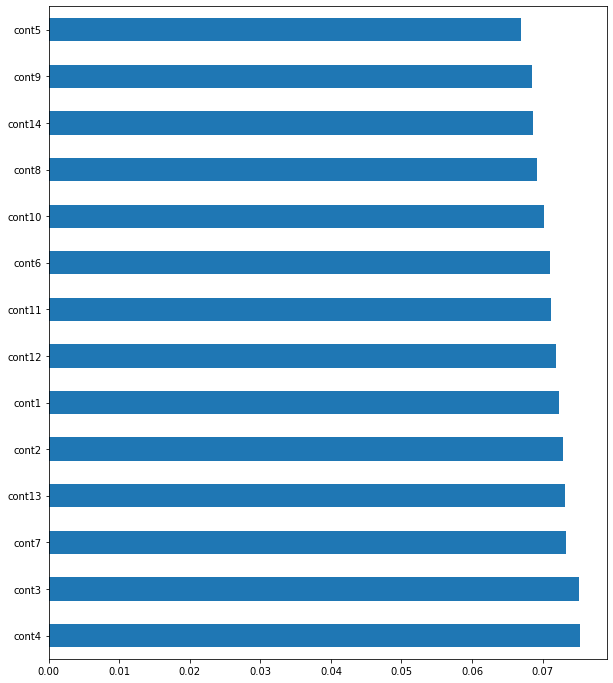

Time used for feature selection: 0:01:18.963581
Attributes to keep:
['cont1', 'cont2', 'cont3', 'cont4', 'cont6', 'cont7', 'cont8', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [52]:
start_time_module = datetime.now()
tree_based_feature_names = list(tree_based_selection(df_features_train, df_target_train))
print ('Time used for feature selection:', (datetime.now() - start_time_module))
print('Attributes to keep:')
print(tree_based_feature_names)

In [53]:
# Evaluate the model with new features
tree_based_features_eval_df = evaluate_model_on_features(df_features_train[tree_based_feature_names], df_target_train)
tree_based_features_eval_df.index = ['Feature importance']

# Append to results and display
results = results.append(tree_based_features_eval_df)
print(results.head(10))

                           MAE       MSE      RMSE        R2  Feature Count
All features          0.542461  0.498791  0.706251  0.071549             14
Correlated features   0.542962  0.504777  0.710477  0.060406             11
Univariate selection  0.548988  0.506564  0.711733  0.057080             12
Sequential selection  0.541635  0.503089  0.709288  0.063547             12
RFE selection         0.542120  0.501667  0.708284  0.066195             12
L1 regularization     0.546096  0.505130  0.710725  0.059748             12
Feature importance    0.542120  0.501667  0.708284  0.066195             12


### 3.e) Display the Final Datasets for Model-Building

In [54]:
# Finalize the training and validation datasets for the modeling activities
array_features_train = df_features_train[rfe_feature_names].to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 12) array_target_train.shape: (300000,)


In [55]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [56]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [57]:
# Not applicable for this iteration of the project

In [58]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [59]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [60]:
# Not applicable for this iteration of the project

In [61]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [62]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [63]:
# Not applicable for this iteration of the project

In [64]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [65]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:48:33.040815
